#### This code is used to analyze the GMM clusters for different numbers of clusters and their shapes.

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
import os
from IPython.core.display import HTML

In [3]:
title_approaches = {
#     'faircal':'Faircal (Theirs)',
    'gmm-discrete':'GMM-Discrete (Ours)'
    }
title_calibration_methods = {
    'beta': 'Beta Calibration'
}
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'
}

title_metrics = {
    'mean': 'Mean',
    'aad': 'AAD',
    'mad': 'MAD',
    'std': 'STD'}

caption_metrics = {
     'mean': 'Mean',
     'aad': 'AAD (Average Absolute Deviation)',
     'mad': 'MAD (Maximum Absolute Deviation)',
     'std': 'STD (Standard Deviation)',
}

title_keys = {
    'gmm-discrete': 'GMM-Discrete (Ours)',
#     'faircal':'Faircal (Theirs)'
    }

header_titles = {
    'African': 'Af',
    'Asian': 'As',
    'Caucasian': 'Ca',
    'Indian': 'In',
    'asian_females': 'AsF',
    'asian_males': 'AsM',
    'black_females': 'AfF',
    'black_males': 'AfM',
    'indian_females': 'IF',
    'indian_males': 'IM',
    'white_females': 'CF',
    'white_males': 'CM',
    'Global': 'Gl',
    'B': 'Af',
    'A': 'As',
    'W': 'C',
    'I': 'I',
    'F': 'F',
    'M': 'M'
}
title_datasets = {
    'rfw': 'RFW',
    'bfw': 'BFW'
}
caption_calibration_methods = {
    'beta': 'beta calibration'
}
caption_measures = {
    'ks': 'KS',
    'ece': 'ECE',
    'brier': 'Brier',
}
features_datasets = {
#     'rfw': ['facenet', 'facenet-webface'],
    'bfw': ['facenet-webface', 'arcface']
}
attributes_datasets = {
    'rfw': 'ethnicity',
    'bfw': 'att',
}

In [11]:
def load_measures(dataset, feature, approach, subgroups, att, measure, calibration_method, nbins, n_clusters):
    filename = f'./experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()

    att = 'e' if dataset == 'bfw' else 'ethnicity'

    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data = data.set_index('folds')
    for fold in range(1, 6):
        for j, subgroup in enumerate(subgroups[att]):
            data.loc[f'fold{str(fold)}', f'{subgroup}'] = results[f'fold{str(fold)}'][measure][att][subgroup]
    return data

In [12]:
subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
att = 'e'
test = load_measures('bfw','facenet-webface','faircal-gmm',subgroups,att,'ks','beta',25,100)
print(test)

          B     A     W         I
folds                            
fold1  0.01  0.03  0.04  1.71e-02
fold2  0.03  0.02  0.02  3.21e-02
fold3  0.04  0.02  0.03  4.62e-02
fold4  0.03  0.05  0.04  7.80e-03
fold5  0.01  0.03  0.04  4.50e-02


In [13]:
def get_sensitive_attributes_subgroups(dataset):
    if dataset == 'rfw':
        sensitive_attributes = ['ethnicity']
        subgroups = {'ethnicity':['African', 'Asian', 'Caucasian', 'Indian']}
    elif 'bfw' in dataset:
        sensitive_attributes = ['e', 'g', 'att']
        subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
    return sensitive_attributes, subgroups

In [18]:
n_clusters = [100]
folds = [1,2,3,4,5]
data = pd.DataFrame()

measure = 'ks'
calibration = 'beta'

indices = {
    'rfw' : {
        'facenet': ['African', 'Asian', 'Caucasian', 'Indian'],
        'facenet-webface': ['African', 'Asian', 'Caucasian', 'Indian'],
    },
    'bfw' : {
        'facenet-webface': ['B', 'A', 'W', 'I', 'F','M', 
            'black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males'],
        'arcface': ['B', 'A', 'W', 'I', 'F','M', 
            'black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']

        }
    }

# Create tuples from multi-indices
approaches = ['faircal', 'faircal-gmm']
tuples = []
for dataset in indices:
    for feature, sens in indices[dataset].items():
        for n_cluster in n_clusters:
            for approach in approaches:
                tuples.append((dataset, feature, n_cluster, approach))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'n_clusters', 'approach'])

data = pd.DataFrame(index=index)
for metric in ['mean', 'aad', 'mad', 'std']:
    data[metric] = np.nan

# For now, because we only have one experiment
for dataset in indices:
    for feature in indices[dataset]:
        for approach in approaches:
            sensitive_attributes, subgroups = get_sensitive_attributes_subgroups(dataset)
            for n_cluster in n_clusters:
                nbins = 25 if dataset == 'bfw' else 10
                try:
                    data_work = load_measures(dataset, feature, approach, subgroups, att, measure, 'beta', nbins=nbins, n_clusters=n_cluster)
                except:
                    continue
                data_work = data_work * 100

                all_subgroups = []
                for subgroup in data_work.columns:
                    all_subgroups.append(data_work[subgroup].tolist())
                    
                all_subgroups = np.hstack(all_subgroups)
                group_mean = all_subgroups.mean()
                
#                 plt.hist(all_subgroups, bins=20)
                print([dataset, feature, approach, str(n_cluster)])
#                 plt.show()
                
                data.loc[dataset, feature, n_cluster, approach]['mean'] = group_mean
                data.loc[dataset, feature, n_cluster, approach]['aad'] = np.abs(all_subgroups - group_mean).mean()
                data.loc[dataset, feature, n_cluster, approach]['mad'] = np.abs(all_subgroups - group_mean).max()
                data.loc[dataset, feature, n_cluster, approach]['std'] = np.std(all_subgroups)

HTML(data.to_html())

['rfw', 'facenet', 'faircal', '100']
['rfw', 'facenet', 'faircal-gmm', '100']
['rfw', 'facenet-webface', 'faircal', '100']
['rfw', 'facenet-webface', 'faircal-gmm', '100']
['bfw', 'facenet-webface', 'faircal', '100']
['bfw', 'facenet-webface', 'faircal-gmm', '100']
['bfw', 'arcface', 'faircal', '100']
['bfw', 'arcface', 'faircal-gmm', '100']


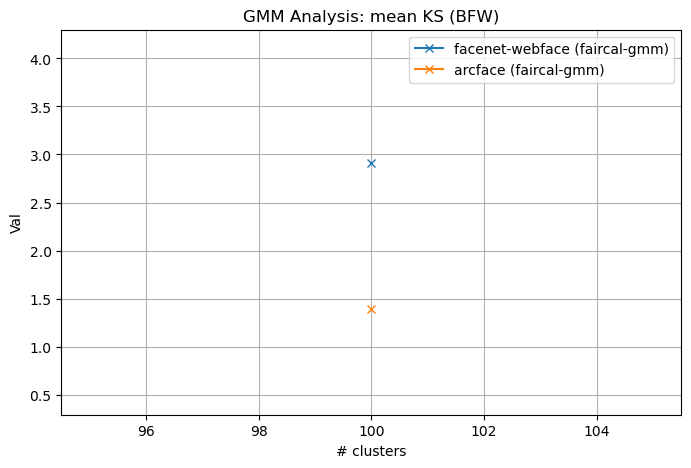

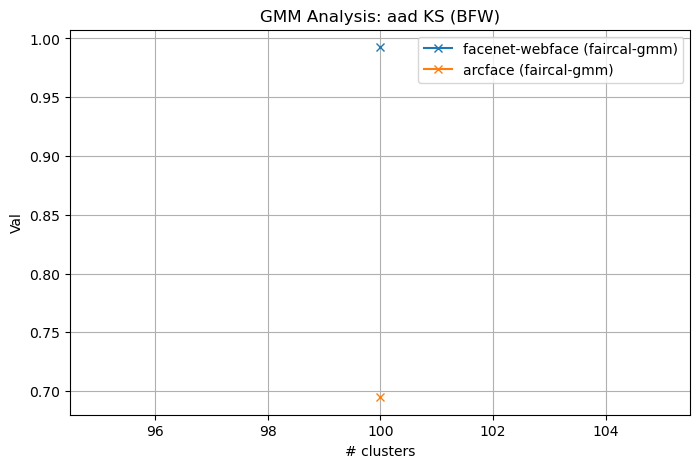

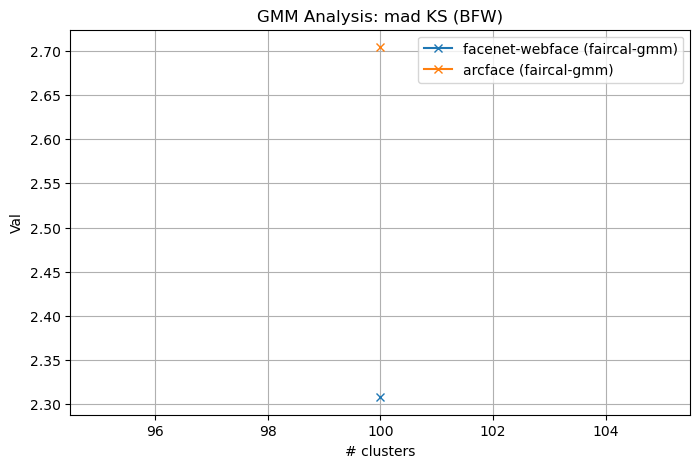

In [15]:
data = data.sort_index()

for metric in ['mean', 'aad', 'mad']:
    plt.figure(figsize=(8, 5))
    for approach in approaches:
        for model in ["facenet-webface", "arcface"]:
            x = data[f'{metric}']["bfw", model, :, approach].index
            y = data[f'{metric}']["bfw", model, :, approach]

            plt.plot(x,y,label=model+f" ({approach})", marker='x')
            if metric == 'mean':
                error = data['std']["bfw", model, :, approach]
                plt.fill_between(x, y-error, y+error, alpha=0.2)

    plt.legend(loc="upper right")
    plt.grid()
    plt.xlabel("# clusters")
    plt.ylabel("Val")
    plt.title(f"GMM Analysis: {metric} {measure.upper()} (BFW)")

    plt.show()

In [20]:
new_df = data[['mean', 'std']]
new_df.sort_index()
new_df['lb'] = np.nan
new_df['ub'] = np.nan
new_df['sig'] = np.nan

approaches = {
    'rfw' : ['facenet', 'facenet-webface'],
    'bfw' : ['facenet-webface', 'arcface']
}

for dataset in ['rfw', 'bfw']:
    for model in approaches[dataset]:
        for n_cluster in n_clusters:
            mean_fc = new_df['mean'][dataset, model, n_cluster, "faircal"]
            mean_gmm = new_df['mean'][dataset, model, n_cluster, "faircal-gmm"]
            std_fc = new_df['std'][dataset, model, n_cluster, "faircal"]
            std_gmm = new_df['std'][dataset, model, n_cluster, "faircal-gmm"]
            
            mean_diff = mean_fc - mean_gmm
            pooled_se = np.sqrt((std_fc**2)/40 + (std_gmm**2)/40)
            
            lb = mean_diff - 1.96*pooled_se
            ub = mean_diff + 1.96*pooled_se
            
            new_df['ub'][dataset, model, n_cluster, "faircal"] = ub
            new_df['lb'][dataset, model, n_cluster, "faircal"] = lb
            new_df['sig'][dataset, model, n_cluster, "faircal"] = not(lb <= 0 <= ub)


new_df['sig'] = new_df['sig'].astype(str).replace({"nan":""})

new_df

C:\Users\marga\AppData\Local\Temp\ipykernel_6764\4204828642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['lb'] = np.nan
C:\Users\marga\AppData\Local\Temp\ipykernel_6764\4204828642.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ub'][dataset, model, n_cluster, "faircal"] = ub
C:\Users\marga\AppData\Local\Temp\ipykernel_6764\4204828642.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

mean   std    lb    ub    sig
dataset feature         n_clusters approach                                  
rfw     facenet         100        faircal      1.67  0.68 -0.44  0.23  False
                                   faircal-gmm  1.77  0.84   NaN   NaN       
        facenet-webface 100        faircal      1.74  0.72 -0.31  0.29  False
                                   faircal-gmm  1.75  0.62   NaN   NaN       
bfw     facenet-webface 100        faircal      2.64  1.03 -0.76  0.22  False
                                   faircal-gmm  2.91  1.20   NaN   NaN       
        arcface         100        faircal      1.68  1.27 -0.19  0.78  False
                                   faircal-gmm  1.39  0.92   NaN   NaN

In [27]:
def get_overall_stats(calibration_method, nbins, dataset,feature,approach,att,n_clusters,fpr_def):
    filename = f'./experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'

    key = 'calibration' if approach in ['faircal', 'baseline', 'faircal-gmm'] else 'pre_calibration'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()
    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data['auc'] = np.nan
    data['fpr_1e-3'] = np.nan
    data['fpr_1e-2'] = np.nan
    data = data.set_index('folds')

    for fold in range(1,6):
        fpr = results['fold'+str(fold)]['fpr'][att]['Global'][key]
        tpr = results['fold'+str(fold)]['tpr'][att]['Global'][key]
        data.loc[f'fold{str(fold)}', 'auc'] = sklearn.metrics.auc(fpr,tpr)
        inter = np.interp(fpr_def, fpr, tpr)
        data.iloc[fold-1, 1:] = inter
    return data

In [28]:
# Accuracy table
keys = ['faircal', 'gmm-discrete']
error = [1e-3, 1e-2]
title_stat = ['AUROC', '0.1\% FPR', '1\% FPR']
n_clusters = [100]
calibration = 'beta'
datasets = ['bfw']

indices = {
#     'rfw' : ['facenet', 'facenet-webface'],
    'bfw' : ['facenet-webface', 'arcface']
}
approaches = ['faircal', 'faircal-gmm']

tuples = []
for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                tuples.append((dataset, feature, approach, cluster))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'approach', 'clusters'])
data = pd.DataFrame(index=index)
metrics = ['auc', 'fpr_1e-3', 'fpr_1e-2']
for metric in metrics:
    data[metric] = ''

for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                nbins = 25 if dataset == 'bfw' else 10
                att = 'att' if dataset == 'bfw' else 'ethnicity'
                data_work = get_overall_stats(calibration, nbins, dataset, feature, approach, att, cluster, error)
                data_work *= 100
                for metric in metrics:
                    mean = round(data_work[metric].mean(), 2)
                    std = round(data_work[metric].std(), 2)
                    data.loc[dataset, feature, approach, cluster][metric] = f'{str(mean)} ({str(std)})'
                
HTML(data.to_html())

                                                       auc      fpr_1e-3  \
dataset feature         approach    clusters                               
bfw     arcface         faircal     100       97.37 (0.35)  84.95 (1.32)   
                        faircal-gmm 100       97.35 (0.37)  84.78 (1.21)   
        facenet-webface faircal     100       95.67 (0.13)  37.68 (0.87)   
                        faircal-gmm 100       95.48 (0.15)  35.39 (1.46)   

                                                  fpr_1e-2  auc_mean  auc_std  \
dataset feature         approach    clusters                                    
bfw     arcface         faircal     100       89.55 (1.01)     97.37     0.35   
                        faircal-gmm 100        89.51 (1.0)     97.35     0.37   
        facenet-webface faircal     100       60.21 (1.09)     95.67     0.13   
                        faircal-gmm 100       58.49 (1.57)     95.48     0.15   

                                              fpr_1e-3_m

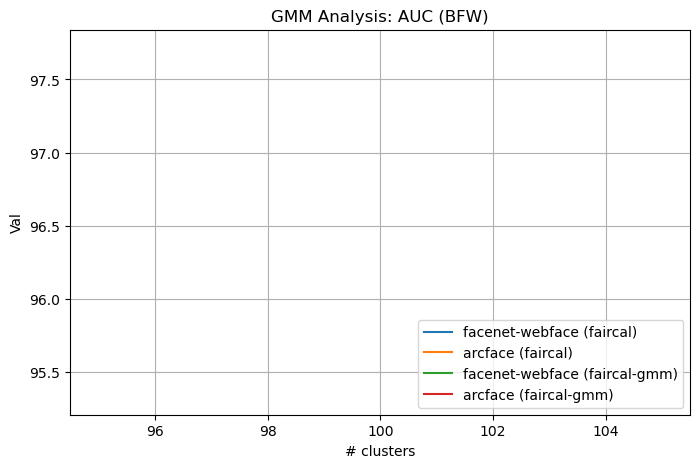

                                                       auc      fpr_1e-3  \
dataset feature         approach    clusters                               
bfw     arcface         faircal     100       97.37 (0.35)  84.95 (1.32)   
                        faircal-gmm 100       97.35 (0.37)  84.78 (1.21)   
        facenet-webface faircal     100       95.67 (0.13)  37.68 (0.87)   
                        faircal-gmm 100       95.48 (0.15)  35.39 (1.46)   

                                                  fpr_1e-2  auc_mean  auc_std  \
dataset feature         approach    clusters                                    
bfw     arcface         faircal     100       89.55 (1.01)     97.37     0.35   
                        faircal-gmm 100        89.51 (1.0)     97.35     0.37   
        facenet-webface faircal     100       60.21 (1.09)     95.67     0.13   
                        faircal-gmm 100       58.49 (1.57)     95.48     0.15   

                                              fpr_1e-3_m

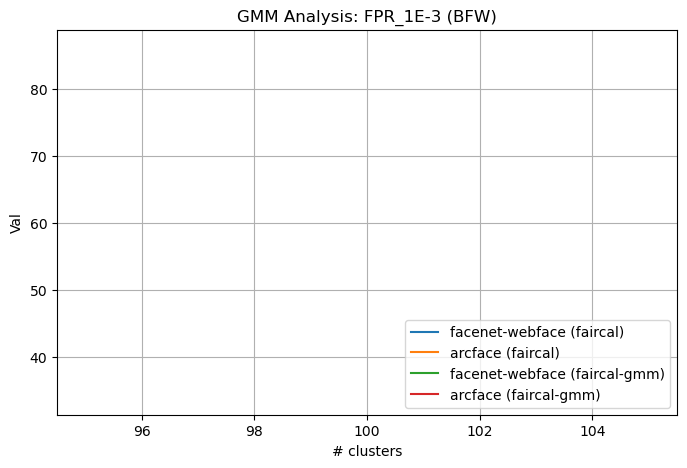

                                                       auc      fpr_1e-3  \
dataset feature         approach    clusters                               
bfw     arcface         faircal     100       97.37 (0.35)  84.95 (1.32)   
                        faircal-gmm 100       97.35 (0.37)  84.78 (1.21)   
        facenet-webface faircal     100       95.67 (0.13)  37.68 (0.87)   
                        faircal-gmm 100       95.48 (0.15)  35.39 (1.46)   

                                                  fpr_1e-2  auc_mean  auc_std  \
dataset feature         approach    clusters                                    
bfw     arcface         faircal     100       89.55 (1.01)     97.37     0.35   
                        faircal-gmm 100        89.51 (1.0)     97.35     0.37   
        facenet-webface faircal     100       60.21 (1.09)     95.67     0.13   
                        faircal-gmm 100       58.49 (1.57)     95.48     0.15   

                                              fpr_1e-3_m

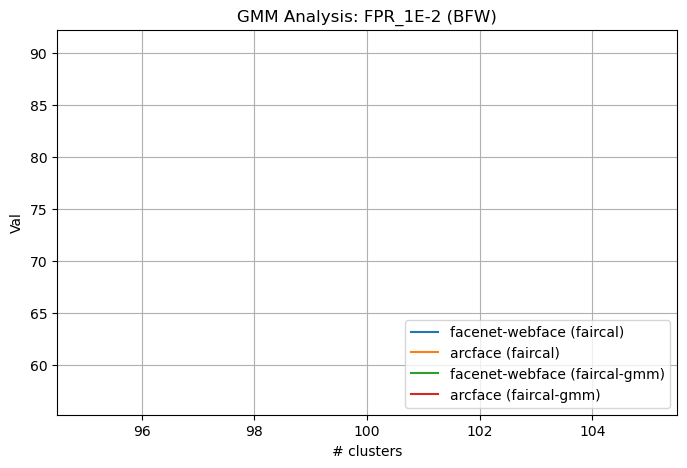

In [30]:
for metric in metrics:
    data[f'{metric}_mean'] = np.nan
    data[f'{metric}_std'] = np.nan
    data[f'{metric}_mean'] = data[metric].apply(lambda x: float(x.split()[0]))
    data[f'{metric}_std'] = data[metric].apply(lambda x: float(x.split()[1][1:-1]))
    data = data.sort_index()
    
    plt.figure(figsize=(8, 5))
    for approach in approaches:
        for model in ["facenet-webface", "arcface"]:
            x = data[f'{metric}_mean']["bfw", model, approach].index
            y = data[f'{metric}_mean']["bfw", model, approach]
            error = data[f'{metric}_std']["bfw", model, approach]
            plt.plot(x,y,label=model+f" ({approach})")
            plt.fill_between(x, y-error, y+error, alpha=0.2)

    print(data)

    plt.legend(loc="lower right")
    plt.grid()
    plt.xlabel("# clusters")
    plt.ylabel("Val")
    plt.title(f"GMM Analysis: {metric.upper()} (BFW)")

    plt.show()

In [39]:
# cluster shape
dataset = 'bfw'
feature = 'facenet-webface'
n_clusters = 100
fold_nr = 1

def load_GMM(dataset, feature, n_clusters, fold_nr):
    filename = f'./experiments/clustering_faircal-gmm/{dataset}_{feature}_nclusters{str(n_clusters)}_fold{str(fold_nr)}'
    results = np.load(f'{filename}.npy', allow_pickle=True).item()
    return results


clusters = load_GMM(dataset, feature, n_clusters, fold_nr)
print(clusters)

c:\Users\marga\.conda\envs\FACTenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
vars(clusters)

{'trainer_params_user': {'accelerator': 'gpu', 'devices': 1},
 'trainer_params': {'logger': False,
  'log_every_n_steps': 1,
  'enable_progress_bar': True,
  'enable_checkpointing': False,
  'enable_model_summary': False,
  'max_epochs': 300,
  'accelerator': 'gpu',
  'devices': 1},
 'batch_size': None,
 'num_clusters': 100,
 'init_strategy': 'kmeans++',
 'convergence_tolerance': 0.0001,
 'model_': KMeansModel(),
 'num_iter_': 300,
 'converged_': False,
 'inertia_': 0.6113011837005615}

In [42]:
clusters.covariances_[0].shape

NotFittedError: `KMeans` has not been fitted yet

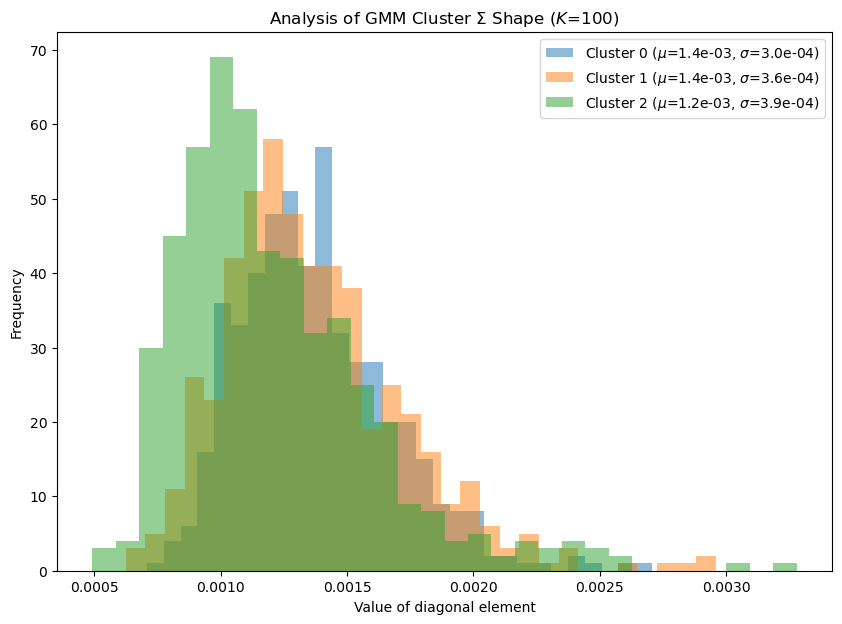

C:\Users\satch\AppData\Local\Temp\ipykernel_86764\3250010370.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_covs = np.hstack(np.diag(clusters.covariances_[i]) for i in range(n_clusters))


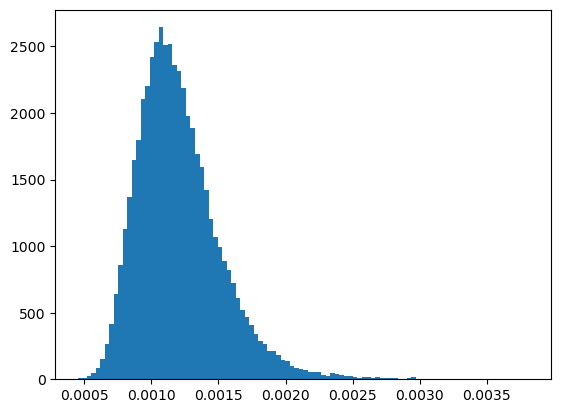

In [ ]:
fig = plt.figure(figsize=(10,7))
for i in range(3):
    diags = np.diag(clusters.covariances_[i])
    plt.hist(diags,bins=30, alpha=0.5, label=f"Cluster {i} ($\mu$={np.mean(diags):.1e}, $\sigma$={np.std(diags):.1e})")
#     plt.plot(clusters.model_.covariances[i], alpha=0.3)

plt.title(f"Analysis of GMM Cluster $\Sigma$ Shape ($K$={n_clusters})")
plt.legend()
plt.xlabel("Value of diagonal element")
plt.ylabel("Frequency")
plt.savefig("diag_hists.png", bbox_inches="tight",dpi=1200)
plt.show()

all_covs = np.hstack(np.diag(clusters.covariances_[i]) for i in range(n_clusters))
plt.hist(all_covs,bins=100)
plt.show()

2.526699047809537
7.9632284919647605


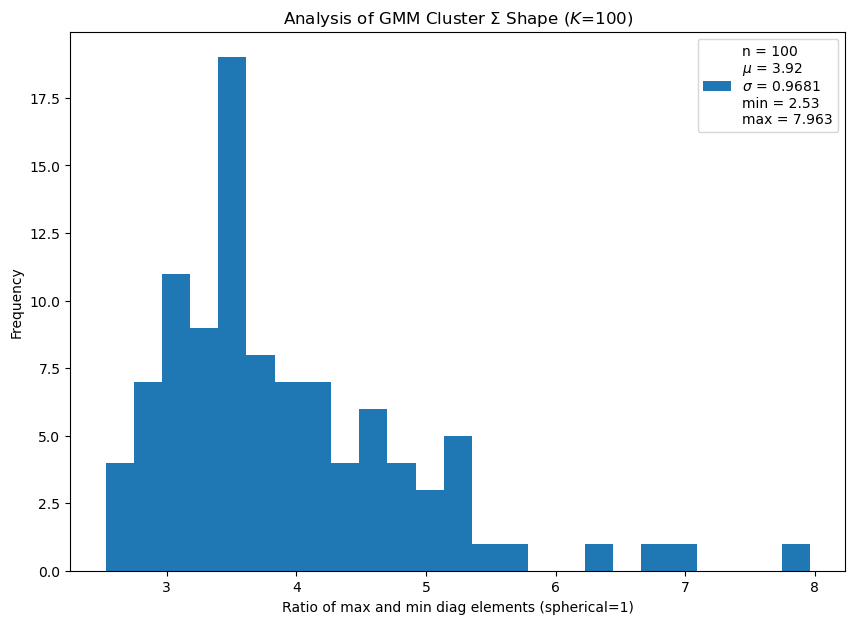

In [ ]:
fig = plt.figure(figsize=(10,7))
diag_ratio = []
for i in range(n_clusters):
#     u,v,ut = np.linalg.svd(clusters.covariances_[i])
#     plt.plot(v)
    v = np.diag(clusters.covariances_[i])
    num = max(v)
    den = min(v)
    diag_ratio.append(float(num/den))


print(min(diag_ratio))
print(max(diag_ratio))
plt.title(f"Analysis of GMM Cluster $\Sigma$ Shape ($K$={n_clusters})")
plt.hist(diag_ratio, bins=25, label=f"n = {len(diag_ratio)}\n$\mu$ = {np.mean(diag_ratio):0.3}\n$\sigma$ = {np.std(diag_ratio):0.4}\nmin = {min(diag_ratio):0.3}\nmax = {max(diag_ratio):0.4}")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Ratio of max and min diag elements (spherical=1)")
plt.savefig("diag_hist_ratios.png", bbox_inches="tight", dpi=1200)
# plt.xlim(0,23)
plt.show()

In [43]:
import pickle as pk
emb = pk.load(open("./embeddings/facenet-webface_bfw_embeddings.pk", 'rb'))
emb

,category,person,image_id,img_path,embedding
0,black_females,n002179,0071_02,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.047579516, -0.0092850095, -0.022012524, -0...."
1,black_females,n002179,0160_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.07423917, 0.0041387347, -0.018063484, 0.009..."
2,black_females,n002179,0103_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.04001123, 0.004318401, -0.035610076, 0.0326..."
3,black_females,n002179,0384_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.04356181, 0.024507862, -0.024504738, 0.0017..."
4,black_females,n002179,0234_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.048189268, 0.08648219, -0.07305223, 0.01209..."
...,...,...,...,...,...
19643,asian_females,n006126,0004_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[0.0067405314, -0.028727228, 0.055191983, -0.0..."
19644,asian_females,n006126,0207_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.023655636, -0.031588852, 0.03558871, -0.02..."
19645,asian_females,n006126,0202_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.014744102, -0.015555788, 0.03138276, -0.02..."
19646,asian_females,n006126,0097_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.012735435, -0.01025463, 0.07161476, -0.029..."


In [44]:
emb_vals = np.vstack(emb['embedding'])

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(emb_vals)
X = pca.transform(emb_vals)
pca.explained_variance_ratio_

array([0.07063751, 0.04641462], dtype=float32)

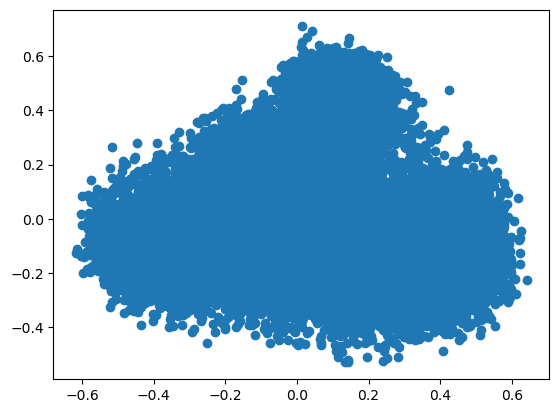

In [46]:
plt.scatter(X[:,0], X[:,1])

In [47]:
emb["reduced_x"] = X[:,0]
emb["reduced_y"] = X[:,1]
emb

,category,person,image_id,img_path,embedding,reduced_x,reduced_y
0,black_females,n002179,0071_02,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.047579516, -0.0092850095, -0.022012524, -0....",-0.26,-0.19
1,black_females,n002179,0160_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.07423917, 0.0041387347, -0.018063484, 0.009...",-0.04,-0.04
2,black_females,n002179,0103_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.04001123, 0.004318401, -0.035610076, 0.0326...",-0.06,-0.18
3,black_females,n002179,0384_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.04356181, 0.024507862, -0.024504738, 0.0017...",-0.12,-0.13
4,black_females,n002179,0234_01,data/bfw/bfw-cropped-aligned/black_females/n00...,"[0.048189268, 0.08648219, -0.07305223, 0.01209...",-0.14,-0.16
...,...,...,...,...,...,...,...
19643,asian_females,n006126,0004_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[0.0067405314, -0.028727228, 0.055191983, -0.0...",0.46,-0.07
19644,asian_females,n006126,0207_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.023655636, -0.031588852, 0.03558871, -0.02...",0.47,-0.10
19645,asian_females,n006126,0202_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.014744102, -0.015555788, 0.03138276, -0.02...",0.49,-0.17
19646,asian_females,n006126,0097_01,data/bfw/bfw-cropped-aligned/asian_females/n00...,"[-0.012735435, -0.01025463, 0.07161476, -0.029...",0.46,-0.16


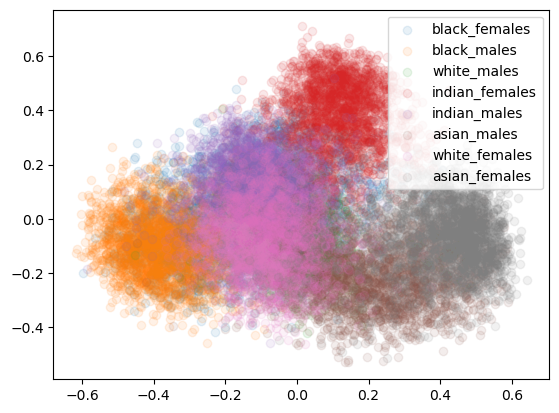

In [48]:
for category in emb["category"].unique():
    sub_df = emb[emb["category"]==category]
    plt.scatter(sub_df['reduced_x'], sub_df['reduced_y'], label=category, alpha=0.1)
    
plt.legend()
plt.show()